
Statistics and Math are the two things which a data scientist must be good at.
## Effect Size

This notebook is a copy of [statistics inference](https://github.com/AllenDowney/CompStats) from Pycon 2016

In [1]:
from __future__ import print_function, division

import numpy
import scipy.stats

import matplotlib.pyplot as pyplot

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# seed the random number generator so we all get the same results
numpy.random.seed(17)

# some nice colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

%matplotlib inline

To explore statistics that quantify effect size, we'll look at the difference in height between men and women. I used data from the Behavioral Risk Factor Surveillance System (BRFSS) to estimate the mean and standard deviation of height in cm for adult women and men in the U.S.

I'll use scipy.stats.norm to represent the distributions. 

The result is an rv object (which stands for random variable).

In [2]:
mu1, sig1 = 178, 7.7
male_height = scipy.stats.norm(mu1, sig1)

In [5]:
mu2, sig2 = 163, 7.3
female_height = scipy.stats.norm(mu2, sig2)

The following function evaluates the normal (Gaussian) probability density function (PDF) within 4 standard deviations of the mean. It takes and rv object and returns a pair of NumPy arrays.

In [6]:
def eval_pdf(rv, num=4):
    mean, std = rv.mean(), rv.std()
    xs = numpy.linspace(mean - num*std, mean + num*std, 100)
    ys = rv.pdf(xs)
    return xs, ys

### Here's what the two distributions look like.

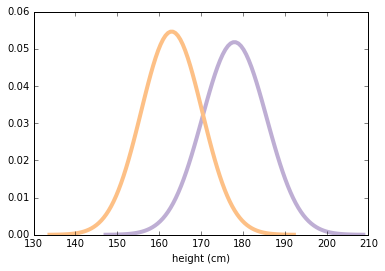

In [7]:
xs, ys = eval_pdf(male_height)
pyplot.plot(xs, ys, label='male', linewidth=4, color=COLOR2)

xs, ys = eval_pdf(female_height)
pyplot.plot(xs, ys, label='female', linewidth=4, color=COLOR3)
pyplot.xlabel('height (cm)')
None

Let's assume for now that those are the true distributions for the population.

I'll use rvs to generate random samples from the population distributions. Note that these are totally random, totally representative samples, with no measurement error!

In [8]:
male_sample = male_height.rvs(1000)

In [11]:
female_sample = female_height.rvs(1000)

##### Both samples are NumPy arrays. Now we can compute sample statistics like the mean and standard deviation.

In [12]:
mean1, std1 = male_sample.mean(), male_sample.std()
mean1, std1

(178.16511665818112, 7.8419961712899502)

#### The sample mean is close to the population mean, but not exact, as expected.

In [13]:
mean2, std2 = female_sample.mean(), female_sample.std()
mean2, std2

(163.48610226651135, 7.382384919896662)

#### And the results are similar for the female sample.
Now, there are many ways to describe the magnitude of the difference between these distributions. An obvious one is the difference in the means:

In [14]:
difference_in_means = male_sample.mean() - female_sample.mean()
difference_in_means # in cm

14.679014391669767

#### On average, men are 14--15 centimeters taller. For some applications, that would be a good way to describe the difference, but there are a few problems:

* Without knowing more about the distributions (like the standard deviations) it's hard to interpret whether a difference like 15 cm is a lot or not.
* The magnitude of the difference depends on the units of measure, making it hard to compare across different studies.

There are a number of ways to quantify the difference between distributions. A simple option is to express the difference as a percentage of the mean.

### What is the relative difference in means, expressed as a percentage?

In [29]:
# Solution goes here

relative_difference = difference_in_means / male_sample.mean()
print(relative_difference * 100)   # percent

# A problem with relative differences is that you have to choose which mean to express them relative to.

relative_difference = difference_in_means / female_sample.mean()
print(relative_difference * 100)   # percent


8.23899462869
8.9787536605


#### An alternative way to express the difference between distributions is to see how much they overlap. 

To define overlap, we choose a threshold between the two means. The simple threshold is the midpoint between the means:

In [23]:
simple_thresh = (mean1 + mean2) / 2
simple_thresh

170.82560946234622

A better, but slightly more complicated threshold is the place where the PDFs cross.

In [24]:
thresh = (std1 * mean2 + std2 * mean1) / (std1 + std2)
thresh

170.6040359174722

#### In this example, there's not much difference between the two thresholds.
Now we can count how many men are below the threshold:

In [25]:
male_below_thresh = sum(male_sample < thresh)
male_below_thresh

164

In [26]:
#And how many women are above it:
female_above_thresh = sum(female_sample > thresh)
female_above_thresh

174

#### The "overlap" is the total area under the curves that ends up on the wrong side of the threshold.

In [27]:
overlap = male_below_thresh / len(male_sample) + female_above_thresh / len(female_sample)
overlap

0.33799999999999997

Or in more practical terms, you might report the fraction of people who would be misclassified if you tried to use height to guess sex:

In [28]:
misclassification_rate = overlap / 2
misclassification_rate

0.16899999999999998

Another way to quantify the difference between distributions is what's called "probability of superiority", which is a problematic term, but in this context it's the probability that a randomly-chosen man is taller than a randomly-chosen woman.

In [31]:
# Suppose I choose a man and a woman at random. What is the probability that the man is taller?
( male_sample > female_sample).sum()/len(male_sample)
#sum(x > y for x, y in zip(male_sample, female_sample)) / len(male_sample)

0.91100000000000003

Overlap (or misclassification rate) and "probability of superiority" have two good properties:
* As probabilities, they don't depend on units of measure, so they are comparable between studies.
* They are expressed in operational terms, so a reader has a sense of what practical effect the difference makes.

### Cohen's d

There is one other common way to express the difference between distributions. Cohen's $d$ is the difference in means, standardized by dividing by the standard deviation. Here's a function that computes it:

In [32]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / numpy.sqrt(pooled_var)
    return d

Computing the denominator is a little complicated; in fact, people have proposed several ways to do it. This implementation uses the "pooled standard deviation", which is a weighted average of the standard deviations of the two groups.

And here's the result for the difference in height between men and women.

In [33]:
CohenEffectSize(male_sample, female_sample)

1.9274780043619493

Most people don't have a good sense of how big $d=1.9$ is, so let's make a visualization to get calibrated.

Here's a function that encapsulates the code we already saw for computing overlap and probability of superiority.

In [34]:
def overlap_superiority(control, treatment, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    control: scipy.stats rv object
    treatment: scipy.stats rv object
    n: sample size
    """
    control_sample = control.rvs(n)
    treatment_sample = treatment.rvs(n)
    thresh = (control.mean() + treatment.mean()) / 2
    
    control_above = sum(control_sample > thresh)
    treatment_below = sum(treatment_sample < thresh)
    overlap = (control_above + treatment_below) / n
    
    superiority = sum(x > y for x, y in zip(treatment_sample, control_sample)) / n
    return overlap, superiority

Here's the function that takes Cohen's $d$, plots normal distributions with the given effect size, and prints their overlap and superiority.

In [35]:
def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    control = scipy.stats.norm(0, 1)
    treatment = scipy.stats.norm(cohen_d, 1)
    xs, ys = eval_pdf(control)
    pyplot.fill_between(xs, ys, label='control', color=COLOR3, alpha=0.7)

    xs, ys = eval_pdf(treatment)
    pyplot.fill_between(xs, ys, label='treatment', color=COLOR2, alpha=0.7)
    
    o, s = overlap_superiority(control, treatment)
    print('overlap', o)
    print('superiority', s)

Here's an example that demonstrates the function:

overlap 0.278
superiority 0.932


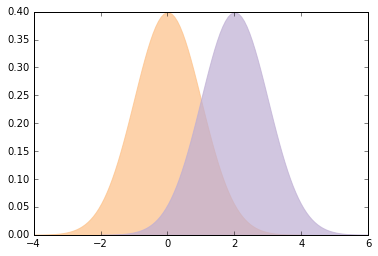

In [36]:
plot_pdfs(2)

And an interactive widget you can use to visualize what different values of $d$ mean

overlap 0.311
superiority 0.93


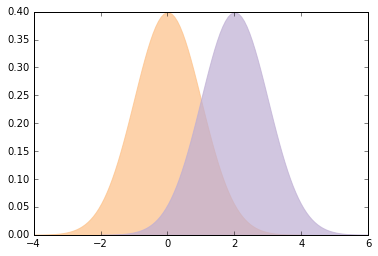

In [38]:
slider = widgets.FloatSlider(min=0, max=4, value=2)
interact(plot_pdfs, cohen_d=slider)
None

Cohen's $d$ has a few nice properties:
* Because mean and standard deviation have the same units, their ratio is dimensionless, so we can compare $d$ across different studies.
* In fields that commonly use $d$, people are calibrated to know what values should be considered big, surprising, or important.
* Given $d$ (and the assumption that the distributions are normal), you can compute overlap, superiority, and related statistics.

In summary, the best way to report effect size often depends on the audience and your goals. There is often a tradeoff between summary statistics that have good technical properties and statistics that are meaningful to a general audience.

## Random Sampling

Suppose we want to estimate the average weight of men and women in the U.S.

And we want to quantify the uncertainty of the estimate.

One approach is to simulate many experiments and see how much the results vary from one experiment to the next.

I'll start with the unrealistic assumption that we know the actual distribution of weights in the population. Then I'll show how to solve the problem without that assumption.

Based on data from the [BRFSS](http://www.cdc.gov/brfss/), I found that the distribution of weight in kg for women in the U.S. is well modeled by a lognormal distribution with the following parameters:

In [39]:
weight = scipy.stats.lognorm(0.23, 0, 70.8)
weight.mean(), weight.std()

(72.697645732966876, 16.944043048498038)

Here's what that distribution looks like:

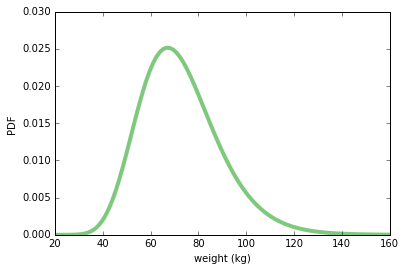

In [40]:
xs = numpy.linspace(20, 160, 100)
ys = weight.pdf(xs)
pyplot.plot(xs, ys, linewidth=4, color=COLOR1)
pyplot.xlabel('weight (kg)')
pyplot.ylabel('PDF')
None

make_sample draws a random sample from this distribution. The result is a NumPy array.

In [41]:
def make_sample(n=100):
    sample = weight.rvs(n)
    return sample

Here's an example with n=100. The mean and std of the sample are close to the mean and std of the population, but not exact.

In [42]:
sample = make_sample(n=100)
sample.mean(), sample.std()

(73.46982665003479, 18.506794373652959)

We want to estimate the average weight in the population, so the "sample statistic" we'll use is the mean:

In [43]:
def sample_stat(sample):
    return sample.mean()

One iteration of "the experiment" is to collect a sample of 100 women and compute their average weight.

We can simulate running this experiment many times, and collect a list of sample statistics. The result is a NumPy array.

In [44]:
def compute_sample_statistics(n=100, iters=1000):
    stats = [sample_stat(make_sample(n)) for i in range(iters)]
    return numpy.array(stats)

The next line runs the simulation 1000 times and puts the results in sample_means:

In [45]:
sample_means = compute_sample_statistics(n=100, iters=1000)

Let's look at the distribution of the sample means. This distribution shows how much the results vary from one experiment to the next.

Remember that this distribution is not the same as the distribution of weight in the population. This is the distribution of results across repeated imaginary experiments.

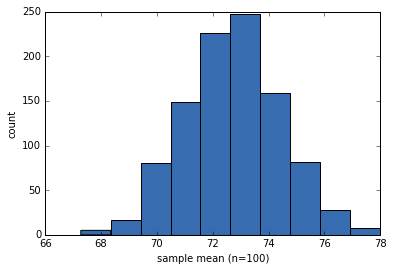

In [46]:
pyplot.hist(sample_means, color=COLOR5)
pyplot.xlabel('sample mean (n=100)')
pyplot.ylabel('count')
None

The mean of the sample means is close to the actual population mean, which is nice, but not actually the important part.

In [47]:
sample_means.mean()

72.721662902624416

The standard deviation of the sample means quantifies the variability from one experiment to the next, and reflects the precision of the estimate.

### This quantity is called the "standard error".

In [48]:
std_err = sample_means.std()
std_err

1.7143793768715117

We can also use the distribution of sample means to compute a "90% confidence interval", which contains 90% of the experimental results:

In [49]:
conf_int = numpy.percentile(sample_means, [5, 95])
conf_int

array([ 69.8793935 ,  75.55835551])

The following function takes an array of sample statistics and prints the SE and CI:

In [50]:
def summarize_sampling_distribution(sample_stats):
    print('SE', sample_stats.std())
    print('90% CI', numpy.percentile(sample_stats, [5, 95]))

And here's what that looks like:

In [51]:
summarize_sampling_distribution(sample_means)

SE 1.71437937687
90% CI [ 69.8793935   75.55835551]


Now we'd like to see what happens as we vary the sample size, n. The following function takes n, runs 1000 simulated experiments, and summarizes the results.

In [52]:
def plot_sample_stats(n, xlim=None):
    sample_stats = compute_sample_statistics(n, iters=1000)
    summarize_sampling_distribution(sample_stats)
    pyplot.hist(sample_stats, color=COLOR2)
    pyplot.xlabel('sample statistic')
    pyplot.xlim(xlim)

Here's a test run with n=100:

SE 1.69812534564
90% CI [ 69.87315704  75.74365323]


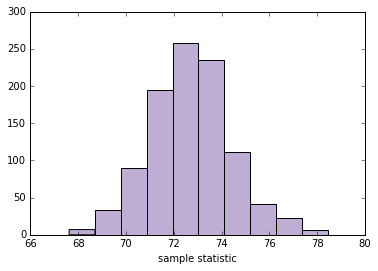

In [53]:
plot_sample_stats(100)

Now we can use interact to run plot_sample_stats with different values of n. Note: xlim sets the limits of the x-axis so the figure doesn't get rescaled as we vary n.

SE 1.70127616447
90% CI [ 70.10977316  75.62828372]


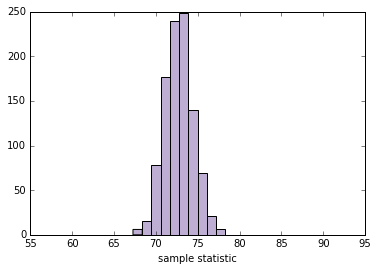

In [54]:
def sample_stat(sample):
    return sample.mean()

slider = widgets.IntSlider(min=10, max=1000, value=100)
interact(plot_sample_stats, n=slider, xlim=fixed([55, 95]))
None

### Other sample statistics
This framework works with any other quantity we want to estimate. By changing sample_stat, you can compute the SE and CI for any sample statistic.

Fill in sample_stat below with any of these statistics:
* Standard deviation of the sample.
* Coefficient of variation, which is the sample standard deviation divided by the sample standard mean.
* Min or Max
* Median (which is the 50th percentile)
* 10th or 90th percentile.
* Interquartile range (IQR), which is the difference between the 75th and 25th percentiles.

NumPy array methods you might find useful include std, min, max, and percentile. Depending on the results, you might want to adjust xlim.

SE 1.79906439728
90% CI [ 13.8356982   19.64748601]


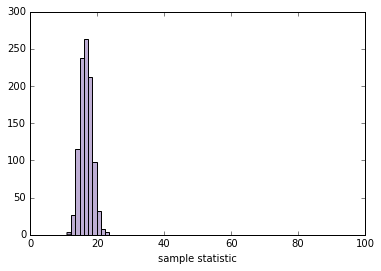

In [56]:
def sample_stat(sample):
    # TODO: replace the following line with another sample statistic
    #return sample.mean()
    return sample.std()
    #return numpy.percentile(sample,50)

slider = widgets.IntSlider(min=10, max=1000, value=100)
interact(plot_sample_stats, n=slider, xlim=fixed([0, 100]))
None

### Modelling - Resampler

So far we have shown that if we know the actual distribution of the population, we can compute the sampling distribution for any sample statistic, and from that we can compute SE and CI.

But in real life we don't know the actual distribution of the population. If we did, we wouldn't need to estimate it!

In real life, we use the sample to build a model of the population distribution, then use the model to generate the sampling distribution. A simple and popular way to do that is "resampling," which means we use the sample itself as a model of the population distribution and draw samples from it.

Before we go on, I want to collect some of the code from Part One and organize it as a class. This class represents a framework for computing sampling distributions.

In [58]:
class Resampler(object):
    """Represents a framework for computing sampling distributions."""
    
    def __init__(self, sample, xlim=None):
        """Stores the actual sample."""
        self.sample = sample
        self.n = len(sample)
        self.xlim = xlim
        
    def resample(self):
        """Generates a new sample by choosing from the original
        sample with replacement.
        """
        new_sample = numpy.random.choice(self.sample, self.n, replace=True)
        return new_sample
    
    def sample_stat(self, sample):
        """Computes a sample statistic using the original sample or a
        simulated sample.
        """
        return sample.mean()
    
    def compute_sample_statistics(self, iters=1000):
        """Simulates many experiments and collects the resulting sample
        statistics.
        """
        stats = [self.sample_stat(self.resample()) for i in range(iters)]
        return numpy.array(stats)
    
    def plot_sample_stats(self):
        """Runs simulated experiments and summarizes the results.
        """
        sample_stats = self.compute_sample_statistics()
        summarize_sampling_distribution(sample_stats)
        pyplot.hist(sample_stats, color=COLOR2)
        pyplot.xlabel('sample statistic')
        pyplot.xlim(self.xlim)

The following function instantiates a Resampler and runs it.

In [59]:
def plot_resampled_stats(n=100):
    sample = weight.rvs(n)
    resampler = Resampler(sample, xlim=[55, 95])
    resampler.plot_sample_stats()

Here's a test run with n=100

SE 1.85614934092
90% CI [ 69.6590065  75.7052664]


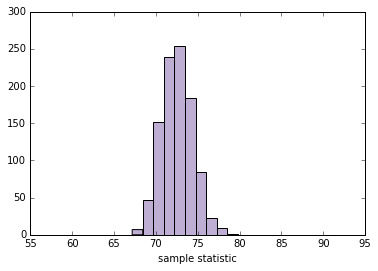

In [60]:
plot_resampled_stats(100)

Now we can use plot_resampled_stats in an interaction:

SE 1.55866939709
90% CI [ 67.92140859  73.12001043]


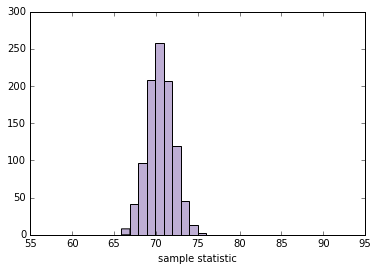

In [61]:
slider = widgets.IntSlider(min=10, max=1000, value=100)
interact(plot_resampled_stats, n=slider, xlim=fixed([1, 15]))
None

write a new class called StdResampler that inherits from Resampler and overrides sample_stat so it computes the standard deviation of the resampled data.

In [62]:
class StdResampler(Resampler):   
    """Computes the sampling distribution of the standard deviation."""
    
    def sample_stat(self, sample):
        """Computes a sample statistic using the original sample or a
        simulated sample.
        """
        return sample.std()

Test your code using the cell below:

SE 1.20134745643
90% CI [ 10.96667057  14.85617734]


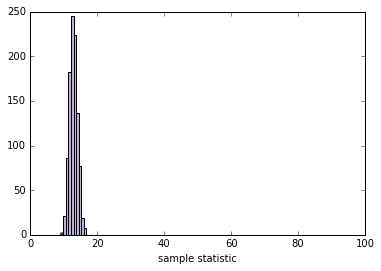

In [64]:
def plot_resampled_stats(n=100):
    sample = weight.rvs(n)
    resampler = StdResampler(sample, xlim=[0, 100])
    resampler.plot_sample_stats()
    
plot_resampled_stats()

When your StdResampler is working, you should be able to interact with it:

SE 1.51885009412
90% CI [ 15.88429776  20.77470288]


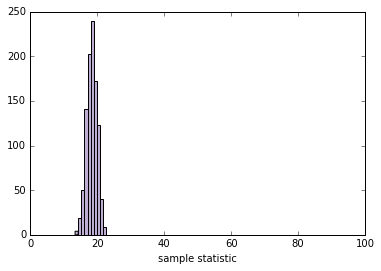

In [65]:
slider = widgets.IntSlider(min=10, max=1000, value=100)
interact(plot_resampled_stats, n=slider)
None

We can extend this framework to compute SE and CI for a difference in means.

For example, men are heavier than women on average. Here's the women's distribution again (from BRFSS data):

In [66]:
female_weight = scipy.stats.lognorm(0.23, 0, 70.8)
female_weight.mean(), female_weight.std()

(72.697645732966876, 16.944043048498038)

And here's the men's distribution:

In [67]:
male_weight = scipy.stats.lognorm(0.20, 0, 87.3)
male_weight.mean(), male_weight.std()

(89.063576984335782, 17.992335889366288)

I'll simulate a sample of 100 men and 100 women:

In [68]:
female_sample = female_weight.rvs(100)
male_sample = male_weight.rvs(100)


The difference in means should be about 17 kg, but will vary from one random sample to the next:

In [69]:
male_sample.mean() - female_sample.mean()

21.81394212085327


Here's the function that computes Cohen's $d$ again:

In [70]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / numpy.sqrt(pooled_var)
    return d

The difference in weight between men and women is about 1 standard deviation:

In [71]:
CohenEffectSize(male_sample, female_sample)

1.245505324392562

Now we can write a version of the Resampler that computes the sampling distribution of $d$.

In [72]:
class CohenResampler(Resampler):
    def __init__(self, group1, group2, xlim=None):
        self.group1 = group1
        self.group2 = group2
        self.xlim = xlim
        
    def resample(self):
        group1 = numpy.random.choice(self.group1, len(self.group1), replace=True)
        group2 = numpy.random.choice(self.group2, len(self.group2), replace=True)
        return group1, group2
    
    def sample_stat(self, groups):
        group1, group2 = groups
        return CohenEffectSize(group1, group2)
    
    # NOTE: The following functions are the same as the ones in Resampler,
    # so I could just inherit them, but I'm including them for readability
    def compute_sample_statistics(self, iters=1000):
        stats = [self.sample_stat(self.resample()) for i in range(iters)]
        return numpy.array(stats)
    
    def plot_sample_stats(self):
        sample_stats = self.compute_sample_statistics()
        summarize_sampling_distribution(sample_stats)
        pyplot.hist(sample_stats, color=COLOR2)
        pyplot.xlabel('sample statistic')
        pyplot.xlim(self.xlim)


Now we can instantiate a CohenResampler and plot the sampling distribution.

SE 0.156763642302
90% CI [ 1.00475806  1.51018268]


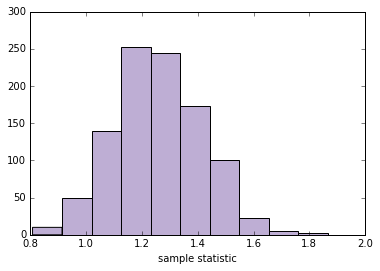

In [73]:
resampler = CohenResampler(male_sample, female_sample)
resampler.plot_sample_stats()


This example demonstrates an advantage of the computational framework over mathematical analysis. Statistics like Cohen's $d$, which is the ratio of other statistics, are relatively difficult to analyze. But with a computational approach, all sample statistics are equally "easy".

One note on vocabulary: what I am calling "resampling" here is a specific kind of resampling called "bootstrapping". Other techniques that are also considering resampling include permutation tests, which we'll see in the next section, and "jackknife" resampling. You can read more at http://en.wikipedia.org/wiki/Resampling_(statistics).